In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip install python-box

In [3]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import random
from datetime import datetime
from time import time
import scipy.sparse as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action='ignore')

# Original

# 1. 학습 설정

In [54]:
config = {
    'data_path' : "/content/gdrive/MyDrive/소융캡/dataset_1m/" , # 데이터 경로

    'model_path' : "/content/gdrive/MyDrive/소융캡/gcn/model", # 모델 저장 경로
    'model_name' : 'LightGCN.pt',

    'num_epochs' : 50,
    "reg" : 1e-5,
    'lr' : 0.0001, #0.0001
    "emb_dim" : 128,
    "n_layers" : 3,
    'batch_size' : 500,
    "node_dropout" : 0.2,

    'valid_samples' : 10, # 검증에 사용할 sample 수
    'seed' : 22,
    'n_batch' : 10,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

In [55]:
if not os.path.isdir(config.model_path):
    os.mkdir(config.model_path)

# 2. 데이터 전처리

In [56]:
class MakeGraphDataSet():
    """
    GraphDataSet 생성
    """
    def __init__(self, config):
        self.config = config
        #self.df = pd.read_csv(os.path.join(self.config.data_path, 'ratings.csv'))

        self.df = pd.read_csv(self.config.data_path + "ratings.dat", sep="::", engine="python",
                      names=["userId", "movieId", "Rating", "timestamp"])

        print(self.df)

        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('movieId')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('userId')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['movieId'].apply(lambda x : self.item_encoder[x])
        self.df['user_idx'] = self.df['userId'].apply(lambda x : self.user_encoder[x])

        self.exist_users = [i for i in range(self.num_user)]
        self.exist_items = [i for i in range(self.num_item)]
        self.user_train, self.user_valid = self.generate_sequence_data()
        self.R_train, self.R_valid, self.R_total = self.generate_dok_matrix()
        self.ngcf_adj_matrix = self.generate_ngcf_adj_matrix()
        self.n_train = len(self.R_train)
        self.batch_size = self.config.batch_size

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder

    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        for user, item in zip(self.df['user_idx'], self.df['item_idx']):
            users[user].append(item)

        for user in users:
            np.random.seed(self.config.seed)

            user_total = users[user]
            #퍼센트로 변경
            sample_size = int(len(user_total) * self.config.valid_samples / 100)
            valid = np.random.choice(user_total, size = sample_size, replace = False).tolist()
            train = list(set(user_total) - set(valid))

            user_train[user] = train
            user_valid[user] = valid # valid_samples 개수 만큼 검증에 활용 (현재 Task와 가장 유사하게)

        return user_train, user_valid

    def generate_dok_matrix(self):
        R_train = sp.dok_matrix((self.num_user, self.num_item), dtype=np.float32)
        R_valid = sp.dok_matrix((self.num_user, self.num_item), dtype=np.float32)
        R_total = sp.dok_matrix((self.num_user, self.num_item), dtype=np.float32)
        user_list = self.exist_users
        for user in user_list:
            train_items = self.user_train[user]
            valid_items = self.user_valid[user]

            for train_item in train_items:
                R_train[user, train_item] = 1.0
                R_total[user, train_item] = 1.0

            for valid_item in valid_items:
                R_valid[user, valid_item] = 1.0
                R_total[user, valid_item] = 1.0

        return R_train, R_valid, R_total

    def generate_ngcf_adj_matrix(self):
        adj_mat = sp.dok_matrix((self.num_user + self.num_item, self.num_user + self.num_item), dtype=np.float32)
        adj_mat = adj_mat.tolil() # to_list
        R = self.R_train.tolil()

        adj_mat[:self.num_user, self.num_user:] = R
        adj_mat[self.num_user:, :self.num_user] = R.T
        adj_mat = adj_mat.todok() # to_dok_matrix

        def normalized_adj_single(adj):
            rowsum = np.array(adj.sum(1))
            d_inv = np.power(rowsum, -.5).flatten()
            d_inv[np.isinf(d_inv)] = 0.
            d_mat_inv = sp.diags(d_inv)
            norm_adj = d_mat_inv.dot(adj).dot(d_mat_inv)

            return norm_adj.tocoo()

        ngcf_adj_matrix = normalized_adj_single(adj_mat)
        return ngcf_adj_matrix.tocsr()

    def sampling(self):
        users = random.sample(self.exist_users, self.config.batch_size)

        def sample_pos_items_for_u(u, num):
            pos_items = self.user_train[u]
            pos_batch = random.sample(pos_items, num)
            return pos_batch

        def sample_neg_items_for_u(u, num):
            neg_items = list(set(self.exist_items) - set(self.user_train[u]))
            neg_batch = random.sample(neg_items, num)
            return neg_batch

        pos_items, neg_items = [], []
        for user in users:
            pos_items += sample_pos_items_for_u(user, 1)
            neg_items += sample_neg_items_for_u(user, 1)

        return users, pos_items, neg_items

    def get_train_valid_data(self):
        return self.user_train, self.user_valid

    def get_R_data(self):
        return self.R_train, self.R_valid, self.R_total

    def get_ngcf_adj_matrix_data(self):
        return self.ngcf_adj_matrix

# 3. 모델

In [57]:
class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, n_layers, reg, node_dropout, adj_mtx):
        super().__init__()

        # initialize Class attributes
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.l = adj_mtx
        self.graph = self._convert_sp_mat_to_sp_tensor(self.l)

        self.reg = reg
        self.n_layers = n_layers
        self.node_dropout = node_dropout

        # Initialize weights
        self.weight_dict = self._init_weights()
        print("Weights initialized.")

    # initialize weights
    def _init_weights(self):
        print("Initializing weights...")
        weight_dict = nn.ParameterDict()

        initializer = torch.nn.init.xavier_uniform_

        weight_dict['user_embedding'] = nn.Parameter(initializer(torch.empty(self.n_users, self.emb_dim).to(device)))
        weight_dict['item_embedding'] = nn.Parameter(initializer(torch.empty(self.n_items, self.emb_dim).to(device)))

        return weight_dict

    # convert sparse matrix into sparse PyTorch tensor
    def _convert_sp_mat_to_sp_tensor(self, X):
        """
        Convert scipy sparse matrix to PyTorch sparse matrix

        Arguments:
        ----------
        X = Adjacency matrix, scipy sparse matrix
        """
        coo = X.tocoo().astype(np.float32)
        i = torch.LongTensor(np.mat([coo.row, coo.col]))
        v = torch.FloatTensor(coo.data)
        res = torch.sparse.FloatTensor(i, v, coo.shape).to(device)
        return res

    # apply node_dropout
    def _droupout_sparse(self, X):
        """
        Drop individual locations in X

        Arguments:
        ---------
        X = adjacency matrix (PyTorch sparse tensor)
        dropout = fraction of nodes to drop
        noise_shape = number of non non-zero entries of X
        """
        node_dropout_mask = ((self.node_dropout) + torch.rand(X._nnz())).floor().bool().to(device)
        i = X.coalesce().indices()
        v = X.coalesce()._values()
        i[:,node_dropout_mask] = 0
        v[node_dropout_mask] = 0
        X_dropout = torch.sparse.FloatTensor(i, v, X.shape).to(X.device)

        return  X_dropout.mul(1/(1-self.node_dropout))

    def forward(self, u, i, j):
        """
        Computes the forward pass

        Arguments:
        ---------
        u = user
        i = positive item (user interacted with item)
        j = negative item (user did not interact with item)
        """
        # apply drop-out mask
        graph = self._droupout_sparse(self.graph) if self.node_dropout > 0 else self.graph
        ego_embeddings = torch.cat([self.weight_dict['user_embedding'], self.weight_dict['item_embedding']], 0)
        final_embeddings = [ego_embeddings]

        for k in range(self.n_layers):
            ego_embeddings = torch.sparse.mm(graph, final_embeddings[k])
            final_embeddings.append(ego_embeddings)

        final_embeddings = torch.stack(final_embeddings, dim=1)
        final_embeddings = torch.mean(final_embeddings, dim=1)

        u_final_embeddings, i_final_embeddings = final_embeddings.split([self.n_users, self.n_items], 0)

        self.u_final_embeddings = nn.Parameter(u_final_embeddings)
        self.i_final_embeddings = nn.Parameter(i_final_embeddings)

        # loss 계산
        u_emb = u_final_embeddings[u] # user embeddings
        p_emb = i_final_embeddings[i] # positive item embeddings
        n_emb = i_final_embeddings[j] # negative item embeddings

        y_ui = torch.sum(torch.mul(u_emb, p_emb), dim = 1)
        y_uj = torch.sum(torch.mul(u_emb, n_emb), dim = 1)

        log_prob = torch.mean(torch.log(torch.sigmoid(y_ui - y_uj)))
        bpr_loss = -log_prob
        if self.reg > 0.:
            l2norm = (torch.sum(u_emb**2)/2. + torch.sum(p_emb**2)/2. + torch.sum(n_emb**2)/2.) / u_emb.shape[0]
            l2reg = self.reg * l2norm
            bpr_loss += l2reg

        return bpr_loss

# 4. 학습 함수

In [58]:
def train(model, make_graph_data_set, optimizer, n_batch):
    model.train()
    loss_val = 0
    for step in range(1, n_batch + 1):
        user, pos, neg = make_graph_data_set.sampling()
        optimizer.zero_grad()
        loss = model(user, pos, neg)
        loss.backward()
        optimizer.step()
        loss_val += loss.item()
    loss_val /= n_batch
    return loss_val

def split_matrix(X, n_splits=10):
    splits = []
    chunk_size = X.shape[0] // n_splits
    for i in range(n_splits):
        start = i * chunk_size
        end = X.shape[0] if i == n_splits - 1 else (i + 1) * chunk_size
        splits.append(X[start:end])
    return splits

def compute_ndcg_k(pred_items, test_items, test_indices, k):

    r = (test_items * pred_items).gather(1, test_indices)
    f = torch.from_numpy(np.log2(np.arange(2, k+2))).float().to(device)

    dcg = (r[:, :k]/f).sum(1)
    dcg_max = (torch.sort(r, dim=1, descending=True)[0][:, :k]/f).sum(1)
    ndcg = dcg/dcg_max

    ndcg[torch.isnan(ndcg)] = 0
    return ndcg

def evaluate(u_emb, i_emb, Rtr, Rte, k = 10):

    # split matrices
    ue_splits = split_matrix(u_emb)
    tr_splits = split_matrix(Rtr)
    te_splits = split_matrix(Rte)

    recall_k, ndcg_k= [], []
    # compute results for split matrices
    for ue_f, tr_f, te_f in zip(ue_splits, tr_splits, te_splits):

        scores = torch.mm(ue_f, i_emb.t())

        test_items = torch.from_numpy(te_f.todense()).float().to(device)
        non_train_items = torch.from_numpy(1-(tr_f.todense())).float().to(device)
        scores = scores * non_train_items

        _, test_indices = torch.topk(scores, dim=1, k=k)

        pred_items = torch.zeros_like(scores).float()
        pred_items.scatter_(dim=1, index=test_indices, src=torch.ones_like(test_indices).float().to(device))

        topk_preds = torch.zeros_like(scores).float()
        topk_preds.scatter_(dim=1, index=test_indices[:, :k], src=torch.ones_like(test_indices).float())

        TP = (test_items * topk_preds).sum(1)
        rec = TP/test_items.sum(1)

        # nan 방지
        rec[torch.isnan(rec)] = 0

        ndcg = compute_ndcg_k(pred_items, test_items, test_indices, k)

        recall_k.append(rec)
        ndcg_k.append(ndcg)

    return torch.cat(ndcg_k).mean(), torch.cat(recall_k).mean()

# 5. 학습

In [59]:
make_graph_data_set = MakeGraphDataSet(config = config)
ngcf_adj_matrix = make_graph_data_set.get_ngcf_adj_matrix_data()
R_train, R_valid, R_total = make_graph_data_set.get_R_data()

         userId  movieId  Rating  timestamp
0             1     1193       5  978300760
1             1      661       3  978302109
2             1      914       3  978301968
3             1     3408       4  978300275
4             1     2355       5  978824291
...         ...      ...     ...        ...
1000204    6040     1091       1  956716541
1000205    6040     1094       5  956704887
1000206    6040      562       5  956704746
1000207    6040     1096       4  956715648
1000208    6040     1097       4  956715569

[1000209 rows x 4 columns]


In [60]:
R_train

<6040x3706 sparse matrix of type '<class 'numpy.float32'>'
	with 902826 stored elements in Dictionary Of Keys format>

In [61]:
R_valid

<6040x3706 sparse matrix of type '<class 'numpy.float32'>'
	with 97383 stored elements in Dictionary Of Keys format>

In [62]:
model = LightGCN(
    n_users = make_graph_data_set.num_user,
    n_items = make_graph_data_set.num_item,
    emb_dim = config.emb_dim,
    n_layers = config.n_layers,
    reg = config.reg,
    node_dropout = config.node_dropout,
    adj_mtx = ngcf_adj_matrix,
    ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

Initializing weights...
Weights initialized.


In [63]:
best_ndcg = 0
patience = 10  # 얼리 스톱핑을 위한 참을성 값
counter = 0  # 얼리 스톱핑을 위한 카운터 값

ndcg_list = []
hit_list = []
train_loss_list = []

stop_flag = False

for epoch in range(1, config.num_epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
        train_loss = train(
            model = model,
            make_graph_data_set = make_graph_data_set,
            optimizer = optimizer,
            n_batch = config.n_batch,
            )
        with torch.no_grad():
            ndcg, hit = evaluate(
                u_emb = model.u_final_embeddings.detach(),
                i_emb = model.i_final_embeddings.detach(),
                Rtr = R_train,
                Rte = R_valid,
                k = 10,
                )
        tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

        ndcg_list.append(ndcg)
        hit_list.append(hit)
        train_loss_list.append(train_loss)

        if ndcg > best_ndcg:
            best_ndcg = ndcg
            torch.save(model.state_dict(), os.path.join(config.model_path, config.model_name))
            counter = 0  # 새로운 최적 값 발견 시 카운터 초기화
        else:
            counter += 1
            if counter >= patience:
              print('')
              print("Early stopping triggered in :  ", best_ndcg)
              stop_flag = True
              break  # 얼리 스톱핑 조건 충족 시 학습 종료
    if stop_flag:
        break

Epoch:   1| Train loss: 0.69313| NDCG@10: 0.02318| HIT@10: 0.00313: 100%|██████████| 1/1 [00:09<00:00,  9.76s/it]
Epoch:   2| Train loss: 0.69312| NDCG@10: 0.02609| HIT@10: 0.00376: 100%|██████████| 1/1 [00:09<00:00,  9.81s/it]
Epoch:   3| Train loss: 0.69311| NDCG@10: 0.03038| HIT@10: 0.00390: 100%|██████████| 1/1 [00:11<00:00, 11.03s/it]
Epoch:   4| Train loss: 0.69311| NDCG@10: 0.03478| HIT@10: 0.00470: 100%|██████████| 1/1 [00:11<00:00, 11.16s/it]
Epoch:   5| Train loss: 0.69310| NDCG@10: 0.04256| HIT@10: 0.00559: 100%|██████████| 1/1 [00:09<00:00,  9.41s/it]
Epoch:   6| Train loss: 0.69310| NDCG@10: 0.05059| HIT@10: 0.00651: 100%|██████████| 1/1 [00:09<00:00,  9.73s/it]
Epoch:   7| Train loss: 0.69309| NDCG@10: 0.06387| HIT@10: 0.00815: 100%|██████████| 1/1 [00:11<00:00, 11.01s/it]
Epoch:   8| Train loss: 0.69307| NDCG@10: 0.08023| HIT@10: 0.01021: 100%|██████████| 1/1 [00:11<00:00, 11.96s/it]
Epoch:   9| Train loss: 0.69306| NDCG@10: 0.10164| HIT@10: 0.01333: 100%|██████████| 1/1


Early stopping triggered in :   tensor(0.2985, device='cuda:0')


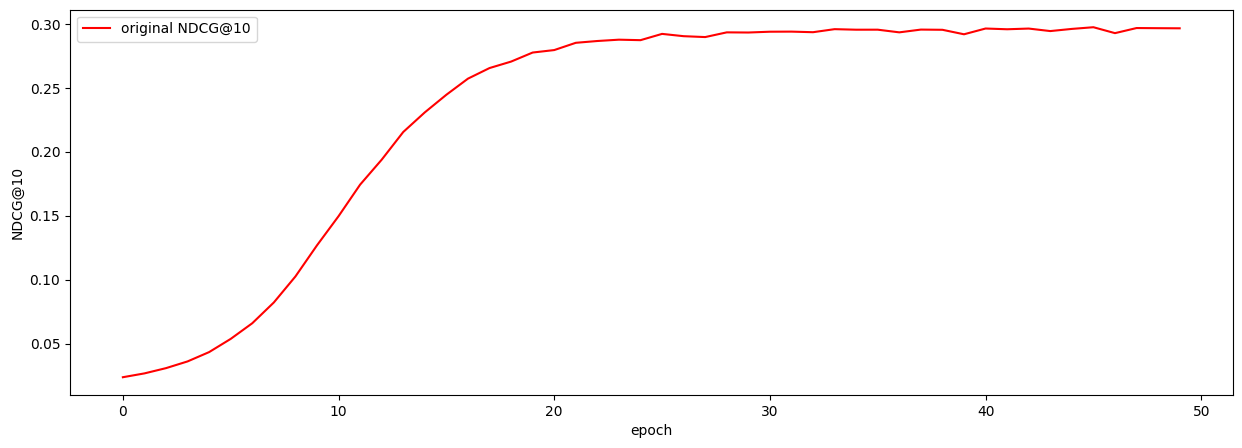

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(ndcg_list, 'r', label = 'original NDCG@10')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('NDCG@10')
loss_ax.legend(loc='upper left')

plt.show()

In [ ]:
make_graph_data_set.num_item

3706

In [ ]:
# 모델 로드
model.load_state_dict(torch.load(os.path.join(config.model_path, config.model_name)))

# 테스트 데이터셋 로드
#test_data = make_graph_data_set.load_data("test")  # 테스트 데이터셋을 로드하는 방법에 따라 수정
test_data = R_train
# 모델을 평가 모드로 설정
model.eval()

# 유저와 아이템 임베딩 추출
u_emb = model.u_final_embeddings.detach()
i_emb = model.i_final_embeddings.detach()

# 추천 리스트 생성
recommendations = []
for user_idx in range(make_graph_data_set.num_item):
    user = test_data[user_idx]

    # 유저와 모든 아이템 간의 예측 점수 계산
    scores = torch.matmul(u_emb[user], i_emb.t())

    # 이미 평가된 아이템은 추천에서 제외하기 위해 -inf로 설정
    scores[user["evaluated_items"]] = float('-inf')

    # 상위 k개의 아이템 추천
    top_k_items = torch.topk(scores, k=config.top_k).indices

    recommendations.append(top_k_items.tolist())

# 결과 출력
for user_idx, user_recommendations in enumerate(recommendations):
    user_id = test_data[user_idx]["user_id"]
    print(f"User: {user_id}")
    print("Recommendations:", user_recommendations)
    print()


IndexError: ignored

# GAN

# 1. 학습 설정

In [42]:
config = {
    'data_path' : "/content/gdrive/MyDrive/소융캡/dataset_1m/" , # 데이터 경로

    'model_path' : "/content/gdrive/MyDrive/소융캡/gcn/model", # 모델 저장 경로
    'model_name' : 'LightGCN_gan.pt',

    'num_epochs' : 50,
    "reg" : 1e-5,
    'lr' : 0.0001, #0.0001
    "emb_dim" : 128,
    "n_layers" : 3,
    'batch_size' : 500,
    "node_dropout" : 0.2,

    'valid_samples' : 10, # 검증에 사용할 sample 수
    'seed' : 22,
    'n_batch' : 10,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

In [43]:
if not os.path.isdir(config.model_path):
    os.mkdir(config.model_path)

# 2. 데이터 전처리

In [44]:
class MakeGraphDataSet():
    """
    GraphDataSet 생성
    """
    def __init__(self, config):
        self.config = config
        #self.df = pd.read_csv(os.path.join(self.config.data_path, 'ratings.csv'))

        self.ratings_df = pd.read_csv(self.config.data_path + "ratings.dat", sep="::", engine="python",
                      names=["UserID", "MovieID", "Rating", "timestamp"])

        self.ratings_df.drop('timestamp', axis=1, inplace=True)

        self.df_fake_GAN = pd.read_csv(self.config.data_path + 'df_fake_GAN.csv')

        self.df = pd.concat([self.ratings_df, self.df_fake_GAN], axis=0, ignore_index=True)

        print(self.df)

        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('MovieID')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('UserID')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['MovieID'].apply(lambda x : self.item_encoder[x])
        self.df['user_idx'] = self.df['UserID'].apply(lambda x : self.user_encoder[x])

        self.exist_users = [i for i in range(self.num_user)]
        self.exist_items = [i for i in range(self.num_item)]
        self.user_train, self.user_valid = self.generate_sequence_data()
        self.R_train, self.R_valid, self.R_total = self.generate_dok_matrix()
        self.ngcf_adj_matrix = self.generate_ngcf_adj_matrix()
        self.n_train = len(self.R_train)
        self.batch_size = self.config.batch_size

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder

    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        for user, item in zip(self.df['user_idx'], self.df['item_idx']):
            users[user].append(item)

        for user in users:
            np.random.seed(self.config.seed)

            user_total = users[user]
            #퍼센트로 변경
            sample_size = int(len(user_total) * self.config.valid_samples / 100)
            valid = np.random.choice(user_total, size = sample_size, replace = False).tolist()
            train = list(set(user_total) - set(valid))

            user_train[user] = train
            user_valid[user] = valid # valid_samples 개수 만큼 검증에 활용 (현재 Task와 가장 유사하게)

        return user_train, user_valid

    def generate_dok_matrix(self):
        R_train = sp.dok_matrix((self.num_user, self.num_item), dtype=np.float32)
        R_valid = sp.dok_matrix((self.num_user, self.num_item), dtype=np.float32)
        R_total = sp.dok_matrix((self.num_user, self.num_item), dtype=np.float32)
        user_list = self.exist_users
        for user in user_list:
            train_items = self.user_train[user]
            valid_items = self.user_valid[user]

            for train_item in train_items:
                R_train[user, train_item] = 1.0
                R_total[user, train_item] = 1.0

            for valid_item in valid_items:
                R_valid[user, valid_item] = 1.0
                R_total[user, valid_item] = 1.0

        return R_train, R_valid, R_total

    def generate_ngcf_adj_matrix(self):
        adj_mat = sp.dok_matrix((self.num_user + self.num_item, self.num_user + self.num_item), dtype=np.float32)
        adj_mat = adj_mat.tolil() # to_list
        R = self.R_train.tolil()

        adj_mat[:self.num_user, self.num_user:] = R
        adj_mat[self.num_user:, :self.num_user] = R.T
        adj_mat = adj_mat.todok() # to_dok_matrix

        def normalized_adj_single(adj):
            rowsum = np.array(adj.sum(1))
            d_inv = np.power(rowsum, -.5).flatten()
            d_inv[np.isinf(d_inv)] = 0.
            d_mat_inv = sp.diags(d_inv)
            norm_adj = d_mat_inv.dot(adj).dot(d_mat_inv)

            return norm_adj.tocoo()

        ngcf_adj_matrix = normalized_adj_single(adj_mat)
        return ngcf_adj_matrix.tocsr()

    def sampling(self):
        users = random.sample(self.exist_users, self.config.batch_size)

        def sample_pos_items_for_u(u, num):
            pos_items = self.user_train[u]
            pos_batch = random.sample(pos_items, num)
            return pos_batch

        def sample_neg_items_for_u(u, num):
            neg_items = list(set(self.exist_items) - set(self.user_train[u]))
            neg_batch = random.sample(neg_items, num)
            return neg_batch

        pos_items, neg_items = [], []
        for user in users:
            pos_items += sample_pos_items_for_u(user, 1)
            neg_items += sample_neg_items_for_u(user, 1)

        return users, pos_items, neg_items

    def get_train_valid_data(self):
        return self.user_train, self.user_valid

    def get_R_data(self):
        return self.R_train, self.R_valid, self.R_total

    def get_ngcf_adj_matrix_data(self):
        return self.ngcf_adj_matrix

# 3. 모델

In [45]:
class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, n_layers, reg, node_dropout, adj_mtx):
        super().__init__()

        # initialize Class attributes
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.l = adj_mtx
        self.graph = self._convert_sp_mat_to_sp_tensor(self.l)

        self.reg = reg
        self.n_layers = n_layers
        self.node_dropout = node_dropout

        # Initialize weights
        self.weight_dict = self._init_weights()
        print("Weights initialized.")

    # initialize weights
    def _init_weights(self):
        print("Initializing weights...")
        weight_dict = nn.ParameterDict()

        initializer = torch.nn.init.xavier_uniform_

        weight_dict['user_embedding'] = nn.Parameter(initializer(torch.empty(self.n_users, self.emb_dim).to(device)))
        weight_dict['item_embedding'] = nn.Parameter(initializer(torch.empty(self.n_items, self.emb_dim).to(device)))

        return weight_dict

    # convert sparse matrix into sparse PyTorch tensor
    def _convert_sp_mat_to_sp_tensor(self, X):
        """
        Convert scipy sparse matrix to PyTorch sparse matrix

        Arguments:
        ----------
        X = Adjacency matrix, scipy sparse matrix
        """
        coo = X.tocoo().astype(np.float32)
        i = torch.LongTensor(np.mat([coo.row, coo.col]))
        v = torch.FloatTensor(coo.data)
        res = torch.sparse.FloatTensor(i, v, coo.shape).to(device)
        return res

    # apply node_dropout
    def _droupout_sparse(self, X):
        """
        Drop individual locations in X

        Arguments:
        ---------
        X = adjacency matrix (PyTorch sparse tensor)
        dropout = fraction of nodes to drop
        noise_shape = number of non non-zero entries of X
        """
        node_dropout_mask = ((self.node_dropout) + torch.rand(X._nnz())).floor().bool().to(device)
        i = X.coalesce().indices()
        v = X.coalesce()._values()
        i[:,node_dropout_mask] = 0
        v[node_dropout_mask] = 0
        X_dropout = torch.sparse.FloatTensor(i, v, X.shape).to(X.device)

        return  X_dropout.mul(1/(1-self.node_dropout))

    def forward(self, u, i, j):
        """
        Computes the forward pass

        Arguments:
        ---------
        u = user
        i = positive item (user interacted with item)
        j = negative item (user did not interact with item)
        """
        # apply drop-out mask
        graph = self._droupout_sparse(self.graph) if self.node_dropout > 0 else self.graph
        ego_embeddings = torch.cat([self.weight_dict['user_embedding'], self.weight_dict['item_embedding']], 0)
        final_embeddings = [ego_embeddings]

        for k in range(self.n_layers):
            ego_embeddings = torch.sparse.mm(graph, final_embeddings[k])
            final_embeddings.append(ego_embeddings)

        final_embeddings = torch.stack(final_embeddings, dim=1)
        final_embeddings = torch.mean(final_embeddings, dim=1)

        u_final_embeddings, i_final_embeddings = final_embeddings.split([self.n_users, self.n_items], 0)

        self.u_final_embeddings = nn.Parameter(u_final_embeddings)
        self.i_final_embeddings = nn.Parameter(i_final_embeddings)

        # loss 계산
        u_emb = u_final_embeddings[u] # user embeddings
        p_emb = i_final_embeddings[i] # positive item embeddings
        n_emb = i_final_embeddings[j] # negative item embeddings

        y_ui = torch.sum(torch.mul(u_emb, p_emb), dim = 1)
        y_uj = torch.sum(torch.mul(u_emb, n_emb), dim = 1)

        log_prob = torch.mean(torch.log(torch.sigmoid(y_ui - y_uj)))
        bpr_loss = -log_prob
        if self.reg > 0.:
            l2norm = (torch.sum(u_emb**2)/2. + torch.sum(p_emb**2)/2. + torch.sum(n_emb**2)/2.) / u_emb.shape[0]
            l2reg = self.reg * l2norm
            bpr_loss += l2reg

        return bpr_loss

# 4. 학습 함수

In [46]:
def train(model, make_graph_data_set, optimizer, n_batch):
    model.train()
    loss_val = 0
    for step in range(1, n_batch + 1):
        user, pos, neg = make_graph_data_set.sampling()
        optimizer.zero_grad()
        loss = model(user, pos, neg)
        loss.backward()
        optimizer.step()
        loss_val += loss.item()
    loss_val /= n_batch
    return loss_val

def split_matrix(X, n_splits=10):
    splits = []
    chunk_size = X.shape[0] // n_splits
    for i in range(n_splits):
        start = i * chunk_size
        end = X.shape[0] if i == n_splits - 1 else (i + 1) * chunk_size
        splits.append(X[start:end])
    return splits

def compute_ndcg_k(pred_items, test_items, test_indices, k):

    r = (test_items * pred_items).gather(1, test_indices)
    f = torch.from_numpy(np.log2(np.arange(2, k+2))).float().to(device)

    dcg = (r[:, :k]/f).sum(1)
    dcg_max = (torch.sort(r, dim=1, descending=True)[0][:, :k]/f).sum(1)
    ndcg = dcg/dcg_max

    ndcg[torch.isnan(ndcg)] = 0
    return ndcg

def evaluate(u_emb, i_emb, Rtr, Rte, k = 10):

    # split matrices
    ue_splits = split_matrix(u_emb)
    tr_splits = split_matrix(Rtr)
    te_splits = split_matrix(Rte)

    hit_k, ndcg_k= [], []
    # compute results for split matrices
    for ue_f, tr_f, te_f in zip(ue_splits, tr_splits, te_splits):

        scores = torch.mm(ue_f, i_emb.t())

        test_items = torch.from_numpy(te_f.todense()).float().to(device)
        non_train_items = torch.from_numpy(1-(tr_f.todense())).float().to(device)
        scores = scores * non_train_items

        _, test_indices = torch.topk(scores, dim=1, k=k)

        pred_items = torch.zeros_like(scores).float()
        pred_items.scatter_(dim=1, index=test_indices, src=torch.ones_like(test_indices).float().to(device))

        topk_preds = torch.zeros_like(scores).float()
        topk_preds.scatter_(dim=1, index=test_indices[:, :k], src=torch.ones_like(test_indices).float())

        TP = (test_items * topk_preds).sum(1)
        rec = TP/test_items.sum(1)

        # nan 방지
        rec[torch.isnan(rec)] = 0

        ndcg = compute_ndcg_k(pred_items, test_items, test_indices, k)

        hit_k.append(rec)
        ndcg_k.append(ndcg)

    return torch.cat(ndcg_k).mean(), torch.cat(hit_k).mean()

# 5. 학습

In [47]:
make_graph_data_set = MakeGraphDataSet(config = config)
ngcf_adj_matrix = make_graph_data_set.get_ngcf_adj_matrix_data()
R_train, R_valid, R_total = make_graph_data_set.get_R_data()

         UserID  MovieID  Rating
0             1     1193       5
1             1      661       3
2             1      914       3
3             1     3408       4
4             1     2355       5
...         ...      ...     ...
2078899   14451     3950       2
2078900   10970     3951       1
2078901   11466     3951       1
2078902   11632     3951       1
2078903   11693     3951       1

[2078904 rows x 3 columns]


In [48]:
R_train

<9918x3725 sparse matrix of type '<class 'numpy.float32'>'
	with 1875355 stored elements in Dictionary Of Keys format>

In [49]:
R_valid

<9918x3725 sparse matrix of type '<class 'numpy.float32'>'
	with 203549 stored elements in Dictionary Of Keys format>

In [50]:
model = LightGCN(
    n_users = make_graph_data_set.num_user,
    n_items = make_graph_data_set.num_item,
    emb_dim = config.emb_dim,
    n_layers = config.n_layers,
    reg = config.reg,
    node_dropout = config.node_dropout,
    adj_mtx = ngcf_adj_matrix,
    ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

Initializing weights...
Weights initialized.


## hit 해결/ k 값 여러개로 진행

In [51]:
best_ndcg = 0
patience = 10  # 얼리 스톱핑을 위한 참을성 값
counter = 0  # 얼리 스톱핑을 위한 카운터 값

ndcg_list_gan = []
hit_list_gan = []
train_loss_list_gan = []

stop_flag = False

for epoch in range(1, config.num_epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
        train_loss = train(
            model = model,
            make_graph_data_set = make_graph_data_set,
            optimizer = optimizer,
            n_batch = config.n_batch,
            )
        with torch.no_grad():
            ndcg, hit = evaluate(
                u_emb = model.u_final_embeddings.detach(),
                i_emb = model.i_final_embeddings.detach(),
                Rtr = R_train,
                Rte = R_valid,
                k = 100,
                )
        tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

        ndcg_list_gan.append(ndcg)
        hit_list_gan.append(hit)
        train_loss_list_gan.append(train_loss)

        if ndcg > best_ndcg:
            best_ndcg = ndcg
            torch.save(model.state_dict(), os.path.join(config.model_path, config.model_name))
            counter = 0  # 새로운 최적 값 발견 시 카운터 초기화
        else:
            counter += 1
            if counter >= patience:
              print('')
              print("Early stopping triggered in :  ", best_ndcg)
              stop_flag = True
              break  # 얼리 스톱핑 조건 충족 시 학습 종료
    if stop_flag:
        break

Epoch:   1| Train loss: 0.69313| NDCG@10: 0.10000| HIT@10: 0.03218: 100%|██████████| 1/1 [00:21<00:00, 21.42s/it]
Epoch:   2| Train loss: 0.69312| NDCG@10: 0.11367| HIT@10: 0.03759: 100%|██████████| 1/1 [00:23<00:00, 23.05s/it]
Epoch:   3| Train loss: 0.69312| NDCG@10: 0.13296| HIT@10: 0.04658: 100%|██████████| 1/1 [00:21<00:00, 21.04s/it]
Epoch:   4| Train loss: 0.69310| NDCG@10: 0.15878| HIT@10: 0.06026: 100%|██████████| 1/1 [00:21<00:00, 21.93s/it]
Epoch:   5| Train loss: 0.69309| NDCG@10: 0.18843| HIT@10: 0.07925: 100%|██████████| 1/1 [00:22<00:00, 22.68s/it]
Epoch:   6| Train loss: 0.69306| NDCG@10: 0.21943| HIT@10: 0.10539: 100%|██████████| 1/1 [00:21<00:00, 21.26s/it]
Epoch:   7| Train loss: 0.69304| NDCG@10: 0.24900| HIT@10: 0.13626: 100%|██████████| 1/1 [00:21<00:00, 21.96s/it]
Epoch:   8| Train loss: 0.69301| NDCG@10: 0.27412| HIT@10: 0.16863: 100%|██████████| 1/1 [00:20<00:00, 20.49s/it]
Epoch:   9| Train loss: 0.69296| NDCG@10: 0.29505| HIT@10: 0.19867: 100%|██████████| 1/1


Early stopping triggered in :   tensor(0.4003, device='cuda:0')


TypeError: ignored

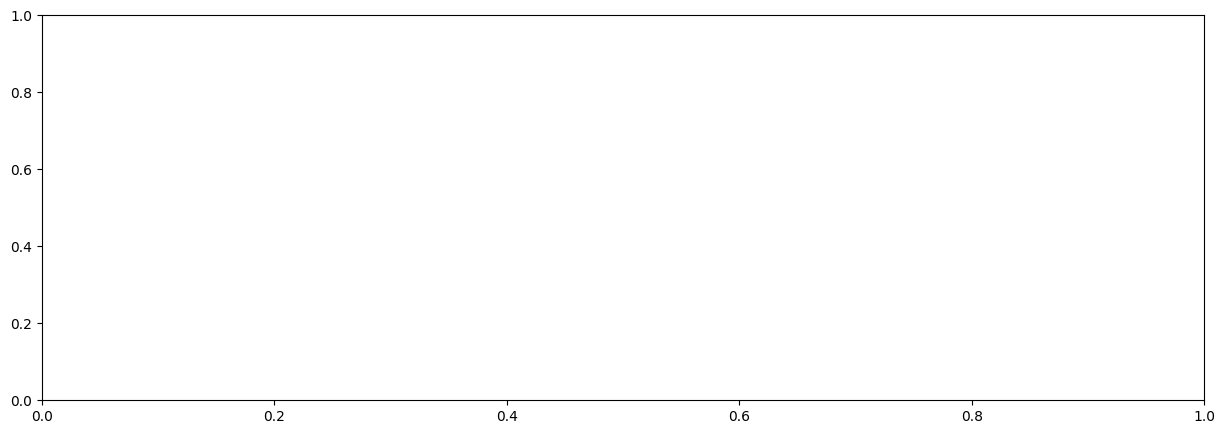

In [53]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(ndcg_list_gan, 'r', label = 'GAN NDCG@10')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('NDCG@10')
loss_ax.legend(loc='upper left')

plt.show()

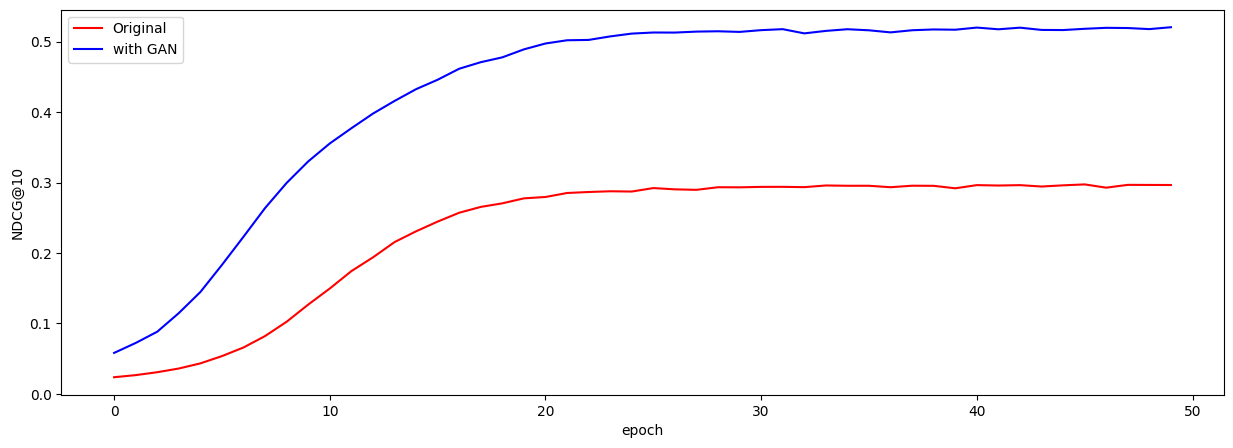

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(ndcg_list, 'r', label = 'Original')
loss_ax.plot(ndcg_list_gan, 'b', label = 'with GAN')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('NDCG@10')
loss_ax.legend(loc='upper left')

plt.show()

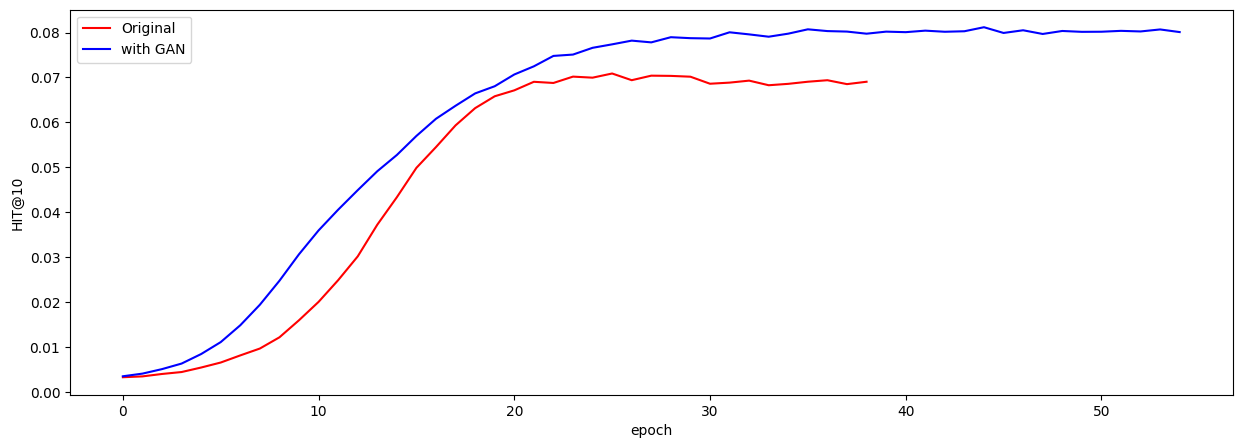

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(hit_list, 'r', label = 'Original')
loss_ax.plot(hit_list_gan, 'b', label = 'with GAN')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('HIT@10')
loss_ax.legend(loc='upper left')

plt.show()